In [ ]:
from collections import defaultdict
import networkx as nx
from networkx import NetworkXError
import pandas as pd
from pyvis.network import Network
from typing import Any
from edge import Edge
from graph_utils import add_dynamic_legend, add_dynamic_legend_to_component_graph
import settings
import json
import random
import numpy as np
from sklearn.manifold import MDS
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from kneed import KneeLocator
import seaborn as sns

In [128]:
def debug(msg: str = "") -> None:
    if settings.DEBUG:
        print(msg)


## Load Dataframe

In [129]:
pd.set_option("display.max_rows", 20)
pd.set_option('display.max_colwidth', None)

df = pd.read_parquet("resources/cleaned_dataframe.parquet", engine="pyarrow")
df

,word_and_gloss,language_and_translation
0,free;;(social) unconstrained.;;not imprisoned or enslaved.,afrikaans;;vrye;;adj
1,free;;(social) unconstrained.;;not imprisoned or enslaved.,albanian;;lirë (i/e);;adj
2,free;;(social) unconstrained.;;not imprisoned or enslaved.,amharic;;ነፃ;;adj
3,free;;(social) unconstrained.;;not imprisoned or enslaved.,arabic;;حُرّ;;adj
4,free;;(social) unconstrained.;;not imprisoned or enslaved.,arabic;;حر;;adj
...,...,...
1188486,fawn response;;(psychology) an overadaptation in response to a traumatic event entailing needs and wants being succumbed to those of the threat actor.,finnish;;miellyttämisreaktio;;noun
1188487,fawn response;;(psychology) an overadaptation in response to a traumatic event entailing needs and wants being succumbed to those of the threat actor.,german;;bambi-reflex;;noun
1188488,fawn response;;(psychology) an overadaptation in response to a traumatic event entailing needs and wants being succumbed to those of the threat actor.,german;;unterwerfungsreaktion;;noun
1188489,"one heart, one soul;;(philippines, catholicism) a saying that is said in every prayer, before the sign of the cross.",latin;;cor ūnum et anima ūna;;phrase


## Filter Dataframe 
### Keep languages with at least 40 translations and keep only translations that appear more than once.

In [130]:
# Count trasnaltions per language
language_counts = df['word_and_gloss'].value_counts()

# filter languages with at least 40 translations
languages_to_keep = language_counts[language_counts >= settings.MIN_LANGUAGE_COUNT].index

# keep rows with filteres languages
df_filtered = df[df['word_and_gloss'].isin(languages_to_keep)]

df_filtered.reset_index(drop = True, inplace=True)
df_filtered

,word_and_gloss,language_and_translation
0,free;;(social) unconstrained.;;not imprisoned or enslaved.,afrikaans;;vrye;;adj
1,free;;(social) unconstrained.;;not imprisoned or enslaved.,albanian;;lirë (i/e);;adj
2,free;;(social) unconstrained.;;not imprisoned or enslaved.,amharic;;ነፃ;;adj
3,free;;(social) unconstrained.;;not imprisoned or enslaved.,arabic;;حُرّ;;adj
4,free;;(social) unconstrained.;;not imprisoned or enslaved.,arabic;;حر;;adj
...,...,...
550348,call the fire department;;(us) call the emergency service that specializes in extinguishing fires.,tagalog;;tawag ka ng bumbero;;phrase
550349,call the fire department;;(us) call the emergency service that specializes in extinguishing fires.,turkish;;itfaiyeyi çağırin;;phrase
550350,call the fire department;;(us) call the emergency service that specializes in extinguishing fires.,turkish;;itfaiyeyi çağır;;phrase
550351,call the fire department;;(us) call the emergency service that specializes in extinguishing fires.,ukrainian;;ви́кличте поже́жників;;phrase


In [131]:
translation_counts = df_filtered["language_and_translation"].value_counts()

# filter translations that appear more than once
translations_to_keep = translation_counts[translation_counts > 1].index

df_filtered = df_filtered[df_filtered['language_and_translation'].isin(translations_to_keep)]

df_filtered.reset_index(drop = True, inplace=True)
df_filtered

,word_and_gloss,language_and_translation
0,free;;(social) unconstrained.;;not imprisoned or enslaved.,arabic;;حُرّ;;adj
1,free;;(social) unconstrained.;;not imprisoned or enslaved.,armenian;;ազատ;;adj
2,free;;(social) unconstrained.;;not imprisoned or enslaved.,assamese;;মুকলি;;adj
3,free;;(social) unconstrained.;;not imprisoned or enslaved.,asturian;;llibre;;adj
4,free;;(social) unconstrained.;;not imprisoned or enslaved.,azerbaijani;;azad;;adj
...,...,...
119553,"shaitan;;(islam) iblis, satan.",turkish;;şeytan;;name
119554,"shaitan;;(islam) iblis, satan.",turkmen;;şeýtan;;name
119555,"shaitan;;(islam) iblis, satan.",urdu;;شَیطان;;name
119556,"shaitan;;(islam) iblis, satan.",uyghur;;شەيتان;;name


In [132]:
unique_lang_and_trans = df_filtered["language_and_translation"].unique()
unique_lang_and_trans

array(['arabic;;حُرّ;;adj', 'armenian;;ազատ;;adj', 'assamese;;মুকলি;;adj',
       ..., 'spanish;;aguar;;verb', 'swedish;;vattna;;verb',
       'portuguese;;dígito;;noun'], dtype=object)

In [133]:
df_filtered["language_and_translation"].nunique()

51999

## Create a Concept Map where each concept has their correspoinding Language, Translation and POS.
## Create a Concept List with all Concepts.

In [134]:
concept_map = dict()
concept_list = set()
def add_concept_to_translation(translation: str, concept: str) -> None:
    concept_list.add(concept)
    if not concept in concept_map:
        concept_map[concept] = set()
    concept_map[concept].add(translation)

df_filtered.apply(lambda row: add_concept_to_translation(row["language_and_translation"], row["word_and_gloss"]), axis=1)

maximum = 0
for key, value in concept_map.items():
    if len(value) > maximum:
        maximum = len(value)
        print(f"{maximum:2d} | {key:32s} | {value}")

59 | free;;(social) unconstrained.;;not imprisoned or enslaved. | {'estonian;;vaba;;adj', 'azerbaijani;;azad;;adj', 'italian;;libero;;adj', 'turkish;;özgür;;adj', 'zazaki;;xoser;;adj', 'ido;;libera;;adj', 'indonesian;;bebas;;adj', 'macedonian;;слободен;;adj', 'assamese;;মুকলি;;adj', 'danish;;fri;;adj', 'czech;;svobodný;;adj', 'limburgish;;vrie;;adj', 'greek;;ελεύθερος;;adj', 'slovak;;slobodný;;adj', 'hebrew;;חופשי;;adj', 'korean;;자유;;adj', 'norman;;libre;;adj', 'russian;;свобо́дный;;adj', 'persian;;آزاد;;adj', 'armenian;;ազատ;;adj', 'old irish;;sóer;;adj', 'galician;;libre;;adj', 'bambara;;hɔrɔn;;adj', 'catalan;;lliure;;adj', 'german;;frei;;adj', 'hebrew;;חָפְשִׁי;;adj', 'low german;;free;;adj', 'norwegian;;fri;;adj', 'polish;;wolny;;adj', 'polish;;swobodny;;adj', 'yiddish;;פֿרײַ;;adj', 'chinese mandarin;;自由的;;adj', 'asturian;;llibre;;adj', 'bashkir;;ирекле;;adj', 'dutch;;vrij;;adj', 'irish;;saor;;adj', 'latvian;;brīvs;;adj', 'northern kurdish;;azad;;adj', 'scottish gaelic;;saor;;adj',

### We have 5315 concepts.

In [135]:
len(concept_list)

5315

### Show first entry of the Concept Map.

In [136]:
first_concept = dict(list(concept_map.items())[:1])
first_concept

{'free;;(social) unconstrained.;;not imprisoned or enslaved.': {'arabic;;حُرّ;;adj',
  'armenian;;ազատ;;adj',
  'assamese;;মুকলি;;adj',
  'asturian;;llibre;;adj',
  'azerbaijani;;azad;;adj',
  'bambara;;hɔrɔn;;adj',
  'bashkir;;ирекле;;adj',
  'catalan;;lliure;;adj',
  'chinese mandarin;;自由的;;adj',
  'czech;;svobodný;;adj',
  'czech;;volný;;adj',
  'danish;;fri;;adj',
  'dutch;;vrij;;adj',
  'esperanto;;libera;;adj',
  'estonian;;vaba;;adj',
  'finnish;;vapaa;;adj',
  'french;;libre;;adj',
  'galician;;libre;;adj',
  'german;;frei;;adj',
  'greek;;ελεύθερος;;adj',
  'hebrew;;חָפְשִׁי;;adj',
  'hebrew;;חופשי;;adj',
  'hungarian;;szabad;;adj',
  'icelandic;;frjáls;;adj',
  'ido;;libera;;adj',
  'indonesian;;bebas;;adj',
  'interlingua;;libere;;adj',
  'irish;;saor;;adj',
  'italian;;libero;;adj',
  'japanese;;自由;;adj',
  'korean;;자유;;adj',
  'latvian;;brīvs;;adj',
  'limburgish;;vrie;;adj',
  'low german;;free;;adj',
  'macedonian;;слободен;;adj',
  'malay;;bebas;;adj',
  'malayalam;;സ്വ

In [137]:
G = nx.Graph()

# Takes about 30 seconds on my machine
edge_map = dict() 
maximum = 0
for i, concept1 in enumerate(concept_list):
    for concept2 in concept_list:
        if concept1 == concept2:
            continue
        
        pair = tuple(sorted([concept1, concept2]))
        if intersection := concept_map[concept1].intersection(concept_map[concept2]):
            edge_map[pair] = Edge(len(intersection), intersection)
            if len(intersection) > maximum:
                maximum = len(intersection)

# Add edges to the graph with weights
for pair, edge in edge_map.items():
    G.add_edge(pair[0], pair[1], weight=edge.weight)

edges = G.edges(data=True)
weights = [edge.weight for edge in edge_map.values()]


In [138]:
sorted_edges = sorted(edges, key = lambda edge: edge[2]['weight'], reverse=True)
print("Strongest connections:")
for parent1, parent2, edge_data in sorted_edges[:5]:
    print(f"(weight: {edge_data['weight']}) {parent1} -- {parent2}")

print("\nWeakest connections:")
for parent1, parent2, edge_data in sorted_edges[-5:]:
    print(f"(weight: {edge_data['weight']}) {parent1} -- {parent2}")

Strongest connections:
(weight: 137) football;;(uk, africa, caribbean, south asia, uncountable) association football, also called soccer: a game in which two teams each contend to get a round ball into the other team's goal primarily by kicking the ball. -- soccer;;(originated, late 19th c, now often us, australia, ireland, philippines, and other countries; see usage notes) association football.
(weight: 129) illness;;(countable) an instance of a disease or poor health. -- disease;;(medicine) an abnormal condition of a human, animal or plant that causes discomfort or dysfunction; distinct from injury insofar as the latter is usually instantaneously acquired.
(weight: 122) speak;;(intransitive) to communicate with one's voice, to say words out loud. -- talk;;(intransitive) to communicate, usually by means of speech.
(weight: 116) soil;;(uncountable) a mixture of mineral particles and organic material, used to support plant growth. -- earth;;(uncountable) soil.
(weight: 115) hide;;(trans

In [139]:
def create_graph(focus_concept: str) -> None:
    """
    Creates an interactive network and saves it as a HTML file.
    
    Args:
        focus_concept (str): The concept for which the network should be created.
        For Example: "free;;(social) unconstrained.;;not imprisoned or enslaved."
    """
    ## Validate input TODO
    try:
        # Get all neighbors of the focus concept
        neighbors = list(G.neighbors(focus_concept))
    except NetworkXError:
        print(f"Invalid focus_concept={focus_concept}. Dataset does not contain this concept.")
        return

    # Create a pyvis network
    net = Network(notebook=False, height="750px", width="100%", bgcolor="#222222", font_color="white")

    # Create a subgraph containing the focus concept and its neighbors
    local_subgraph = G.subgraph([focus_concept] + neighbors)

    # Map edges to the languages that connect them
    edge_to_languages = defaultdict(tuple)

    subgraph_maximum = 0
    for pair in local_subgraph.edges():
        pair = tuple(sorted(list(pair)))
        edge = edge_map[pair]
        edge_to_languages[pair] = edge.value

        if edge.weight > subgraph_maximum:
            subgraph_maximum = edge.weight


    # Add nodes to the pyvis network
    for node in local_subgraph.nodes:
        net.add_node(node, title=node, label=node.split(settings.SEPERATOR)[0])

    # Add edges with language information
    for pair, languages in edge_to_languages.items():
        edge: Edge = edge_map[pair]
        value = edge.weight
        width = edge.normalized(subgraph_maximum)
        net.add_edge(*pair, value=value, languages=', '.join(languages), width=width)

    # Save graph to a temporary file
    temp_file = "temp_network.html"
    net.save_graph(temp_file)

    # Add dynamic legend to the HTML file
    add_dynamic_legend(temp_file, edge_to_languages, focus_concept)

    print(f"Saved html Network '{focus_concept}'.")

## Two Example Subgraphs

In [140]:
#create_graph("pyramid;;(geometry) a solid with triangular lateral faces and a polygonal (often square or rectangular) base.")
create_graph("free;;(social) unconstrained.;;not imprisoned or enslaved.")

Saved html Network 'free;;(social) unconstrained.;;not imprisoned or enslaved.'.


In [141]:
weight_threshold = 5 # too high?

# remove edges under threshold
edges_to_remove = [(u, v) for u, v, data in G.edges(data=True) if data['weight'] < weight_threshold]
G.remove_edges_from(edges_to_remove)

# Graph Depth 2 (Nur für Visualisierung)
d2_graph = nx.Graph()
for node in G.nodes():
    subgraph = nx.ego_graph(G, node, radius=2)
    d2_graph.add_edges_from(subgraph.edges(data=True))

# Remove duplicate edges
d2_graph = nx.Graph(d2_graph)

# Seperate graph into zusammenhangskomponenten
components = list(nx.connected_components(d2_graph))

# Create Graph for each component
def create_html(component, index):
    component_graph = d2_graph.subgraph(component)

    net = Network(notebook=False, height="100vh", bgcolor="#222222", font_color="white")

    for node in component_graph.nodes:
        net.add_node(node, title=node, label=node.split(";;")[0])

    # Calculcate the global maximum of edge weights for the component
    try:
        component_maximum = max(
            edge_map[pair].weight for pair in component_graph.edges
            if pair in edge_map  # Check if edge exists in edge_map
        )
    except ValueError:
        # If no edges exist, set default component maximum on 1
        component_maximum = 1
        #print(f"Component {index + 1} has no edges in edge_map. Use default value for component_maximum.")

    # Add edges with weights and Information
    edge_to_languages = defaultdict(tuple)
    for u, v, data in component_graph.edges(data=True):
        pair = tuple(sorted([u, v]))
        if pair in edge_map:   # Check if edge exists in edge_map
            edge = edge_map[pair]
            value = edge.weight
            languages = edge.value
            width = edge.normalized(component_maximum)  # Use max of the component for normalization
            net.add_edge(u, v, value=value, languages=', '.join(languages), width=width)
            edge_to_languages[pair] = edge.value

    # save graph in a html file
    output_file = f"component_graphs/component_{index + 1}_graph.html"
    net.save_graph(output_file)

    # Add dynamix language legend
    add_dynamic_legend_to_component_graph(output_file, edge_to_languages, f"component_{index + 1}_graph")

In [142]:
def save_results_to_file(results, filename):
    """
    Saves results to a JSON file.
    """
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(results, f, indent=4)
        

def random_walk_in_component(component_graph, start_node, walk_length):
    """
    Performs a random walk in a component. Ganz oft aufrufen auf dem gleichen (für alle im graphen) Knoten udn dann wahrscheinlichkeitsverteilung über output (5% dieser Knoten, 10% anmderer usw.)
    """
    current_node = start_node 

    for _ in range(walk_length - 1):
        neighbors = list(component_graph.neighbors(current_node)) + [current_node]
        next_node = random.choice(neighbors)
        current_node = next_node

    return current_node


def find_longest_path_approx(component_graph, max_depth=None) -> int:
    """
    Get the longest path. 
    :return: Number of nodes of the longest path.
    """
    longest_path_length = 0
    for node in component_graph.nodes:
        # Depth is 2 * number of nodes
        if max_depth is None:
            max_depth = component_graph.number_of_nodes()
        path_length = nx.single_source_shortest_path(component_graph, node, cutoff=max_depth) # not path, lengths
        longest_path_length = max(longest_path_length, len(path_length))
    return longest_path_length


def process_all_components(d2_graph):
    """
    Processes all connected components of the graph.
    """
    components = list(nx.connected_components(d2_graph))

    for index, component in enumerate(components):

        # Create a visualisation for the component
        create_html(component=component, index=index)
        
        component_graph = d2_graph.subgraph(component)

        # Get the longest path
        longest_path = find_longest_path_approx(component_graph)

        # random walk
        start_node = list(component_graph.nodes)[0]  # start
        walk_length = longest_path  # Lieber bei zweimal bleiben
        random_walk = random_walk_in_component(component_graph, start_node, walk_length)
        # wahrscheinlichkeitsverteilung von jedem Knoten zu einem anderem, führt aber zu vielen 0, 10% abziehen von allen die ich schon habe, dividieren durch anzahl der 0 werte und dazuaddieren
        # sparse matrix (default wert kann eingestellt werden.)

        summary = {
            "component_id": index + 1,
            "num_nodes": component_graph.number_of_nodes(),
            "num_edges": component_graph.number_of_edges(),
            "density": nx.density(component_graph),
            "longest_path": walk_length,
            "random_walk": random_walk
        }

        save_results_to_file(summary, f"component_graphs/component_{index + 1}_summary.json")

        # uncomment
        #print(f"Component {index + 1} processed and saved.")

process_all_components(d2_graph)

In [143]:
from typing import Dict, List

random_count: int = 10

def get_matrix_for_component_graph(component_graph: nx.Graph) -> List[List[int]]:
    """
    ...

    :param component_graph: The graph to calculate the matrix from
    :return: The len(nodes) x len(nodes) matrix containing every start stop pair
    """
    path_len: int = find_longest_path_approx(component_graph=component_graph)

    # Sort component_grpah nodes for a consistent matrix representation (index=node)
    nodes = sorted(component_graph.nodes)
    debug("\n  ".join(["Sorted Node Index:"] + nodes))

    # Run random_walk starting from every node once and save the last visited node
    start_stop_map: Dict[str, str] = {node: [random_walk_in_component(component_graph=component_graph, 
                                                                      start_node=node, 
                                                                      walk_length=path_len) for _ in range(random_count)] 
                                      for node in nodes}

    # Initialize matrix full of 0   
    matrix: List[List[int]] = [[0 for _ in range(len(nodes))] for _ in range(len(nodes))]

    # Add 1 to every start stop pair and devide by node_count * walk_count
    for start, end_nodes in start_stop_map.items():
        for end in end_nodes:
            matrix[nodes.index(start)][nodes.index(end)] = matrix[nodes.index(start)][nodes.index(end)] + (1 / (random_count))

    debug()
    debug('\n  '.join(["EndNode Percentages:"] + [", ".join([f"{value:0.4f}" for value in row]) for row in matrix]))
    debug()
    debug(f"Sum of percentages: {sum([sum(row) for row in matrix])}")
    debug(f"Sum per row: {[sum(row) for row in matrix]}\nrows: {len(matrix)}\n1/rows: {1/len(matrix)}")

    return matrix, nodes

# Example 
component_graph = d2_graph.subgraph(components[0])
matrix = get_matrix_for_component_graph(component_graph)


In [144]:
total_nodes = len(G.nodes())
matrix = np.zeros((total_nodes, total_nodes))
components = list(nx.connected_components(G))
node_to_index = {}
# Get matrix for every component in G
for i, component in enumerate(components):
    graph = G.subgraph(component)

    # Exclude big graph for dev reason
    if len(graph.nodes) < 100:
        m, nodes = get_matrix_for_component_graph(component_graph=graph)
        
        # Loop over row of component matrix
        for i, row in enumerate(m):

            # Add node to node_idx map
            node_to_index[nodes[i]] = len(node_to_index)
            for j, value in enumerate(row):             
                matrix[len(node_to_index)][len(node_to_index) + j] = value


# Smoothing factor 10% for the 0 transitions inbetween the component graphs
smoothing_factor = 0.1

for i in range(matrix.shape[0]):
    z = max(1, np.count_nonzero(matrix[i]==0))
    for j in range(matrix.shape[1]):
        if matrix[i][j] == 0:
            matrix[i][j] = smoothing_factor / z
        else:
            matrix[i][j] *= (1 - smoothing_factor)

# should be ~"number of rows/cols" (here: 5315)
# can differ greatly due to rounding errors
print(np.sum(matrix), matrix.shape[0]) 


4687.699999999898 5315


In [145]:
len(components)

2712

In [146]:
matrix

array([[1.88146754e-05, 1.88146754e-05, 1.88146754e-05, ...,
        1.88146754e-05, 1.88146754e-05, 1.88146754e-05],
       [1.88323917e-05, 1.80000000e-01, 1.80000000e-01, ...,
        1.88323917e-05, 1.88323917e-05, 1.88323917e-05],
       [1.88359390e-05, 1.88359390e-05, 9.00000000e-02, ...,
        1.88359390e-05, 1.88359390e-05, 1.88359390e-05],
       ...,
       [1.88146754e-05, 1.88146754e-05, 1.88146754e-05, ...,
        1.88146754e-05, 1.88146754e-05, 1.88146754e-05],
       [1.88146754e-05, 1.88146754e-05, 1.88146754e-05, ...,
        1.88146754e-05, 1.88146754e-05, 1.88146754e-05],
       [1.88146754e-05, 1.88146754e-05, 1.88146754e-05, ...,
        1.88146754e-05, 1.88146754e-05, 1.88146754e-05]])

https://stats.stackexchange.com/questions/134504/using-an-asymmetric-distance-matrix-for-clustering

In [147]:
def avg(a:float, b: float) -> float:
    """
    Calculcates the average of two values.
    """
    return (a + b)/2


aggs = [min, max, avg]
agg = aggs[2]


for i in range(matrix.shape[0]):
    for j in range(i):
        matrix[i][j] = matrix[j][i] = agg(matrix[i][j], matrix[j][i])

In [148]:
matrix

array([[1.88146754e-05, 1.88235336e-05, 1.88253072e-05, ...,
        1.88146754e-05, 1.88146754e-05, 1.88146754e-05],
       [1.88235336e-05, 1.80000000e-01, 9.00094180e-02, ...,
        1.88235336e-05, 1.88235336e-05, 1.88235336e-05],
       [1.88253072e-05, 9.00094180e-02, 9.00000000e-02, ...,
        1.88253072e-05, 1.88253072e-05, 1.88253072e-05],
       ...,
       [1.88146754e-05, 1.88235336e-05, 1.88253072e-05, ...,
        1.88146754e-05, 1.88146754e-05, 1.88146754e-05],
       [1.88146754e-05, 1.88235336e-05, 1.88253072e-05, ...,
        1.88146754e-05, 1.88146754e-05, 1.88146754e-05],
       [1.88146754e-05, 1.88235336e-05, 1.88253072e-05, ...,
        1.88146754e-05, 1.88146754e-05, 1.88146754e-05]])

In [149]:
dist_matrix = 1 - matrix

In [150]:
dist_matrix

array([[0.99998119, 0.99998118, 0.99998117, ..., 0.99998119, 0.99998119,
        0.99998119],
       [0.99998118, 0.82      , 0.90999058, ..., 0.99998118, 0.99998118,
        0.99998118],
       [0.99998117, 0.90999058, 0.91      , ..., 0.99998117, 0.99998117,
        0.99998117],
       ...,
       [0.99998119, 0.99998118, 0.99998117, ..., 0.99998119, 0.99998119,
        0.99998119],
       [0.99998119, 0.99998118, 0.99998117, ..., 0.99998119, 0.99998119,
        0.99998119],
       [0.99998119, 0.99998118, 0.99998117, ..., 0.99998119, 0.99998119,
        0.99998119]])

https://stackoverflow.com/questions/54055761/checking-triangle-inequality-in-a-massive-numpy-matrix

In [151]:
def check_triangle_inequality(matrix, num_checks):
    """
    Randomly samples triplets (i, j, k) from distance matrix D
    and checks if D[i, j] <= D[i, k] + D[k, j] for all sampled triplets.
    
    Parameters:
        D (ndarray): 2D symmetric distance matrix.
        num_checks (int): Number of triplets to check.
        verbose (bool): If True, prints details of violations.

    Returns:
        bool: True if all sampled triplets satisfy the inequality, else False.
    """
    violations = 0

    for _ in range(num_checks):
        i, j, k = random.sample(range(matrix.shape[0]), 3)
        dij = matrix[i, j]
        dik = matrix[i, k]
        dkj = matrix[k, j]

        if dij > dik + dkj + 1e-8:
            violations += 1

    print(f"\nTotal Violations: {violations} out of {num_checks} checks")

    return violations == 0


result = check_triangle_inequality(dist_matrix, num_checks=10_000_000)



Total Violations: 0 out of 10000000 checks


In [152]:
np.fill_diagonal(dist_matrix, 0)

In [153]:
dist_matrix

array([[0.        , 0.99998118, 0.99998117, ..., 0.99998119, 0.99998119,
        0.99998119],
       [0.99998118, 0.        , 0.90999058, ..., 0.99998118, 0.99998118,
        0.99998118],
       [0.99998117, 0.90999058, 0.        , ..., 0.99998117, 0.99998117,
        0.99998117],
       ...,
       [0.99998119, 0.99998118, 0.99998117, ..., 0.        , 0.99998119,
        0.99998119],
       [0.99998119, 0.99998118, 0.99998117, ..., 0.99998119, 0.        ,
        0.99998119],
       [0.99998119, 0.99998118, 0.99998117, ..., 0.99998119, 0.99998119,
        0.        ]])

In [154]:
max_dim = 16
dims = range(1, max_dim + 1)
stress_vals = []

for d in tqdm(dims, desc="Running MDS", unit="dimension"):
    mds = MDS(n_components=d, dissimilarity='precomputed', random_state=42)
    mds.fit(dist_matrix)
    stress_vals.append(mds.stress_)
    print(f"Dimension {d} → Stress: {mds.stress_:.2f}")


Running MDS:   6%|▋         | 1/16 [00:12<03:00, 12.05s/dimension]

Dimension 1 → Stress: 4704921.90


Running MDS:  12%|█▎        | 2/16 [01:05<08:33, 36.66s/dimension]

Dimension 2 → Stress: 2504691.20


Running MDS:  19%|█▉        | 3/16 [09:38<55:02, 254.01s/dimension]

Dimension 3 → Stress: 1566689.75


Running MDS:  25%|██▌       | 4/16 [12:34<44:38, 223.19s/dimension]

Dimension 4 → Stress: 1095805.99


Running MDS:  31%|███▏      | 5/16 [16:58<43:37, 237.99s/dimension]

Dimension 5 → Stress: 839565.01


Running MDS:  38%|███▊      | 6/16 [23:16<47:36, 285.60s/dimension]

Dimension 6 → Stress: 679466.74


Running MDS:  44%|████▍     | 7/16 [31:30<53:03, 353.67s/dimension]

Dimension 7 → Stress: 570252.18


Running MDS:  50%|█████     | 8/16 [41:54<58:37, 439.74s/dimension]

Dimension 8 → Stress: 491133.10


Running MDS:  56%|█████▋    | 9/16 [53:16<1:00:08, 515.49s/dimension]

Dimension 9 → Stress: 431252.66


Running MDS:  62%|██████▎   | 10/16 [1:04:08<55:44, 557.50s/dimension]

Dimension 10 → Stress: 384434.75


Running MDS:  69%|██████▉   | 11/16 [1:12:23<44:52, 538.51s/dimension]

Dimension 11 → Stress: 346910.31


Running MDS:  75%|███████▌  | 12/16 [1:17:45<31:30, 472.60s/dimension]

Dimension 12 → Stress: 315985.14


Running MDS:  81%|████████▏ | 13/16 [1:22:12<20:31, 410.37s/dimension]

Dimension 13 → Stress: 290004.58


Running MDS:  88%|████████▊ | 14/16 [1:26:14<11:58, 359.47s/dimension]

Dimension 14 → Stress: 267941.41


Running MDS:  94%|█████████▍| 15/16 [1:29:37<05:12, 312.17s/dimension]

Dimension 15 → Stress: 248982.39


Running MDS: 100%|██████████| 16/16 [1:32:48<00:00, 348.05s/dimension]

Dimension 16 → Stress: 232514.73


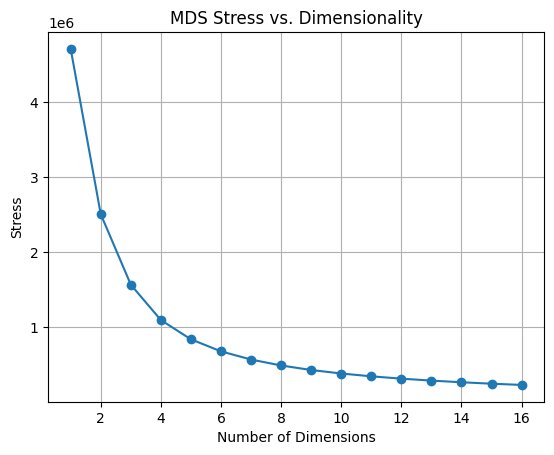

In [ ]:
plt.plot(dims, stress_vals, marker='o')
plt.xlabel("Number of Dimensions")
plt.ylabel("Stress")
plt.title("MDS Stress vs. Dimensionality")
plt.grid(True)
plt.show()

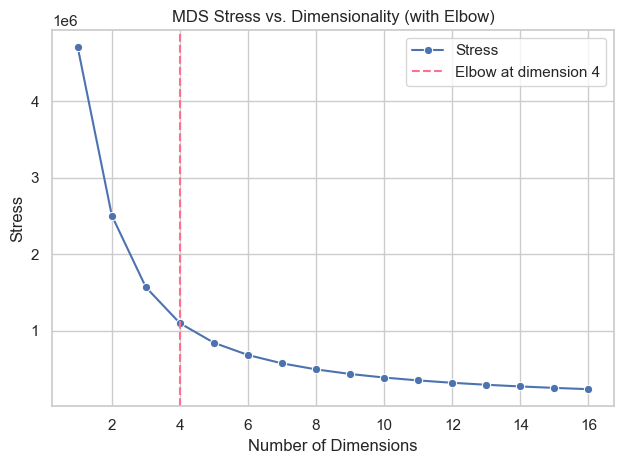

In [ ]:
dims = list(range(1, len(stress_vals) + 1))

knee = KneeLocator(dims, stress_vals, curve="convex", direction="decreasing")

sns.lineplot(x=dims, y=stress_vals, marker='o', label="Stress")

plt.axvline(x=knee.knee, color='#FF6F91', linestyle='--', label=f"Elbow at dimension {knee.knee}")
plt.title("MDS Stress vs. Dimensionality (with Elbow)")
plt.xlabel("Number of Dimensions")
plt.ylabel("Stress")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
stress = np.array(stress_vals)

delta_1 = np.diff(stress)
delta_2 = np.diff(delta_1)


if np.all(delta_2 >= 0):
    print("The stress curve is strictly convex.")
elif np.all(delta_2[:-1] >= -1e-6):
    print("The curve is mostly convex (with minor noise).")
else:
    print("The curve is not convex.")


The stress curve is strictly convex.
